# Predicting Bike Rentals

The purpose of this project is to predict the total number of bicycles rented in a given hour, using various machine learning techniques. The dataset for this project is a record of bike rentals in the District of Columbia. The data is taken from the University of California, Irvine's Machine Learning Repository and [can be found here.](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

To begin, I will import the necessary libraries and open the relevant file into a pandas dataframe.

In [37]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import machine learning libraries
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

# Allowing for viewing of large file
pd.set_option('max_columns', 180)
pd.set_option('max_rows', 200000)
pd.set_option('max_colwidth', 5000)

In [22]:
# Reading in the csv file
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

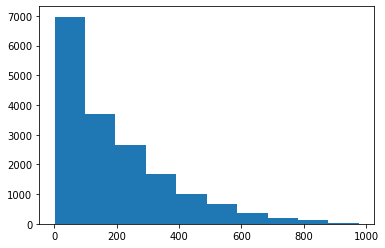

In [23]:
# Viewing a histogram of the count column

plt.hist(bike_rentals["cnt"])

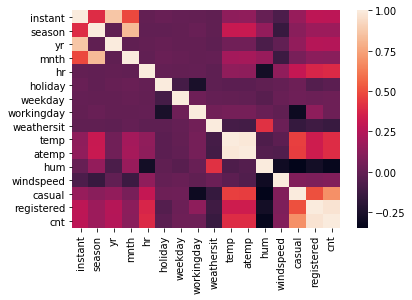

In [24]:
# Exploring correlation matrix
bike_corr = bike_rentals.corr()
sns.heatmap(bike_corr)

In [25]:
# Exploring correlation values
count_corr = abs(bike_rentals.corr()['cnt'])
count_corr.sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

# Feature Engineering

I will create a labeled feature that breaks the generic `'hr'` feature into more useful categories for time of day.

In [26]:
# creating function for determining time of day
def assign_label(hour):
    if (hour >= 6) & (hour < 12):
        return 1
    elif (hour >= 12) & (hour < 18):
        return 2
    elif (hour >= 18) & (hour < 24):
        return 3
    elif (hour >= 0) & (hour < 6):
        return 4

In [27]:
# using assign_label to interpret each item in hour column
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

## Error Metric

For this model, I will use Root Mean Squared Error as the error metric. This will work well with the data in the `'count'` column, as it is numeric and continuous. In addition, a RMSE value will compare understandably with the number of bikes rented per hour.

## Building Linear Regression Model

To begin, I will write a function to train and test various models on the data:

In [28]:
# def a function for training/testing
def train_and_test(df, k=0):
    # splitting dataframe from target column
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop('cnt')
    lr=linear_model.LinearRegression()
    
    # holdout validation
    if k == 0:
        # splitting dataframe into train/test segments
        train = df.sample(frac=.8)
        test = df.loc[~df.index.isin(train.index)]
    
        lr.fit(train[features], train['cnt'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['cnt'], predictions)
        rmse = np.sqrt(mse) 
        return rmse
    
    # simple cross validation
    if k == 1:
        # Randomizing all rows from df
        shuffled_df = df.sample(frac=1, )
        # splitting dataframe into train/test segments
        train = df.sample(frac=.8)
        test = df.loc[~df.index.isin(train.index)]
        
        # training data
        lr.fit(train[features], train['cnt'])
        predictions_one = lr.predict(test[features])
        mse_one = mean_squared_error(test['cnt'], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        # test data
        lr.fit(test[features], test['cnt'])
        predictions_two = lr.predict(train[features])
        mse_two = mean_squared_error(train['cnt'], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        # averaging rmse
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one, rmse_two)
        return avg_rmse
    
    # K-fold validation
    else:
        # building K-folds
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            # creating train/test set for fold
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            # fitting and predicting
            lr.fit(train[features], train['cnt'])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test['cnt'], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        # Averaging rmse values
        avg_rmse = np.mean(rmse_values)
        print(avg_rmse)
        return avg_rmse

## Feature Selection

Before running the model, I will examine the current features to delete any which will not add value to the model.

Features to drop:
* instant
* casual (proxy for rental)
* registered (proxy for rental)
* dteday (redundant)

Features to dummy (categorical):
* season
* weathersit

In [29]:
# Dropping unnecessary columns
dropcols = ['instant', 'dteday', 'casual', 'registered']
bike_rentals.drop(columns=dropcols, inplace=True)

In [33]:
# Getting dummies for others
seasondummies = pd.get_dummies(bike_rentals['season'],prefix='season')
weatherdummies = pd.get_dummies(bike_rentals['weathersit'], prefix='weathersit')
rentalsdf = pd.concat([bike_rentals, seasondummies, weatherdummies], axis=1)

In [35]:
# Dropping original dummy columns
dropcols = ['season', 'weathersit']
rentalsdf.drop(columns=dropcols, inplace=True)
rentalsdf.head()

,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,time_label,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,1,0,0,6,0,0.24,0.2879,0.81,0.0,16,4,1,0,0,0,1,0,0,0
1,0,1,1,0,6,0,0.22,0.2727,0.80,0.0,40,4,1,0,0,0,1,0,0,0
2,0,1,2,0,6,0,0.22,0.2727,0.80,0.0,32,4,1,0,0,0,1,0,0,0
3,0,1,3,0,6,0,0.24,0.2879,0.75,0.0,13,4,1,0,0,0,1,0,0,0
4,0,1,4,0,6,0,0.24,0.2879,0.75,0.0,1,4,1,0,0,0,1,0,0,0


## Linear Regression

To begin, I will train and fit a Linear Regression model on the data. I will do this using three main validation methods:
* Holdout validation
* Simple cross validation
* K-fold validation

In [38]:
# Holdout validation
train_and_test(rentalsdf, k=0)

132.6540059527994

In [39]:
# Simple cross validation
train_and_test(rentalsdf, k=1)

129.51708468300356 131.90617240408903


130.71162854354628

In [41]:
# K-fold validation
# testing to optimize k-fold value
k_range = list(range(2,20,1))
rmses = {}
for i in k_range:
    rmse = train_and_test(rentalsdf, k=i)
    rmses[i] = rmse
    
# Using min() + list comprehension + values() 
# Finding min value keys in dictionary 
temp = min(rmses.values()) 
res = [key for key in rmses if rmses[key] == temp] 
  
# printing result  
print("Model with minimum rmse is: " + "k = " + str(res) + ", rmse = " + str(temp))

131.36881518700756
131.35212117772323
131.39616639531963
131.32089925023794
131.32569576056036
131.31045471138677
131.32482093265858
131.3193103980885
131.34877025260158
131.26342060092975
131.29896138776317
131.2992432566921
131.27452301947343
131.28569815398558
131.31231214445273
131.30130476780573
131.3332074126031
131.23299796937795
Model with minimum rmse is: k = [19], rmse = 131.23299796937795


### Linear Regression Results

After running these various validation methods, the best linear regression model is a simple cross-validation model, with an 80/20 train/test split.

The RSME for this model is 130.7, which means we are able to estimate riders with a variance of 130 riders per hour. However, given that the overall mean of the `'cnt'` category is 189, with a standard deviation of 181, this model is not very helpful.

In [42]:
rentalsdf['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

## Decision Tree Method

Next, I will fit a Decision Tree regression model to the data and see if the accuracy is improved.

In [45]:
# Importing Decision Tree model
from sklearn.tree import DecisionTreeRegressor

# splitting dataframe from target column
features = rentalsdf.columns.drop('cnt')

# Recreating train and test groups
train = rentalsdf.sample(frac=.8)
test = rentalsdf.loc[~rentalsdf.index.isin(train.index)]

# Fitting Decision Tree model
reg = DecisionTreeRegressor(min_samples_leaf=5)
reg.fit(train[features], train["cnt"])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [47]:
# Making predictions on test set
predictions = reg.predict(test[features])
np.sqrt(np.mean((predictions-test['cnt'])**2))

54.969567934379405

### Decision Tree Results

The decision tree regressor appears to have reduced the error significantly, increasing the accuracy of the model. 

## Random Forest model

Finally, I will try a Random Forest regression model.

In [48]:
# Importing Random Forest
from sklearn.ensemble import RandomForestRegressor

# Fitting model to data
reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[features], train["cnt"])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [49]:
# Making predictions on test set
predictions = reg.predict(test[features])
np.sqrt(np.mean((predictions-test['cnt'])**2))

44.03460743880083

# Final Results

In the end, the three models delivered different levels of accuracy, as defined by RMSE:
* Linear Regression (Simple cross validation): 130.7
* Decision Tree: 55.0
* Random Forest: 44.0

As a result, the Random Forest model has produced the most accurately-fitting model to predict bike rentals by hour.